# Description

This notebook reads the number of variants in each GWAS (generated by `02-count_gwas_variants.ipynb`) and then it groups GWASs acording to that number.

The results are groups of GWAS ("cohorts") with the same number of variants. This is a quick way to see which GWAS share the same variants, which is needed to compute gene correlation matrices later for each cohort.

Some of the cohorts are "Rapid GWAS project" (`rapid`), "Astle" (`astle`) and "Others" (`others`). These are GWASs on different traits that were processed with the same pipeline, and thus they share the same set of variants. The exception is "Others", which is a mix of GWAS but with a similar number of variants.

# Modules

In [45]:
import sqlite3
from pathlib import Path

import numpy as np
import pandas as pd
from tqdm import tqdm

import conf

# Settings

In [2]:
GWAS_PARSING_BASE_DIR = conf.PHENOMEXCAN["BASE_DIR"] / "gwas_parsing"
display(GWAS_PARSING_BASE_DIR)
GWAS_PARSING_BASE_DIR.mkdir(exist_ok=True, parents=True)

PosixPath('/opt/data/data/phenomexcan/gwas_parsing')

In [3]:
GWAS_PARSING_N_LINES_DIR = GWAS_PARSING_BASE_DIR / "gwas_parsing_n_lines"
display(GWAS_PARSING_N_LINES_DIR)
GWAS_PARSING_N_LINES_DIR.mkdir(exist_ok=True, parents=True)

PosixPath('/opt/data/data/phenomexcan/gwas_parsing/gwas_parsing_n_lines')

In [4]:
GWAS_PARSING_INPUT_DIR = GWAS_PARSING_BASE_DIR / "full"
display(GWAS_PARSING_INPUT_DIR)
assert GWAS_PARSING_INPUT_DIR.exists()

PosixPath('/opt/data/data/phenomexcan/gwas_parsing/full')

# Load data

## Phenotype info from PhenomeXcan

In [5]:
pheno_info = pd.read_csv(conf.PHENOMEXCAN["UNIFIED_PHENO_INFO_FILE"], sep="\t")

In [6]:
pheno_info.shape

(4091, 10)

In [7]:
pheno_info.head()

,pheno_id,full_code,short_code,description,unique_description,type,n,n_cases,n_controls,source
0,0,100001_raw-Food_weight,100001_raw,Food weight,Food weight,continuous_raw,51453,NaN,NaN,UK Biobank
1,1,100002_raw-Energy,100002_raw,Energy,Energy,continuous_raw,51453,NaN,NaN,UK Biobank
2,2,100003_raw-Protein,100003_raw,Protein,Protein,continuous_raw,51453,NaN,NaN,UK Biobank
3,3,100004_raw-Fat,100004_raw,Fat,Fat,continuous_raw,51453,NaN,NaN,UK Biobank
4,4,100005_raw-Carbohydrate,100005_raw,Carbohydrate,Carbohydrate,continuous_raw,51453,NaN,NaN,UK Biobank


In [89]:
pheno_info["source"].value_counts()

UK Biobank          4049
Astle_et_al_2016      14
MAGNETIC               4
BCAC                   3
IBD                    3
SSGAC                  2
Jones_et_al_2016       2
PGC                    2
MAGIC                  2
CNCR-CTG               1
ENIGMA                 1
CARDIoGRAM_C4D         1
GEFOS                  1
EAGLE                  1
IGAP                   1
EGG                    1
IMMUNOBASE             1
GIANT                  1
RA_OKADA               1
Name: source, dtype: int64

## GWAS number of variants

In [8]:
gwas_n_variants = pd.read_pickle(GWAS_PARSING_BASE_DIR / "gwas_n_variants.pkl")
display(gwas_n_variants)

M13_FOREIGNBODY     8496089
22617_7112          8496089
M13_ANKLEFOOT       8496089
22601_81212774      8496089
40001_J841          8496089
                     ...   
20551_1             8496089
20003_1140882728    8496089
20003_1141172924    8496089
K08                 8496089
20003_1199          8496089
Name: 0, Length: 4197, dtype: int64

In [9]:
# keep only those phenotypes present in PhenomeXcan
_common_pheno_codes = gwas_n_variants.index.intersection(set(pheno_info["short_code"]))
assert len(_common_pheno_codes) == pheno_info.shape[0]

In [10]:
gwas_n_variants = gwas_n_variants.loc[_common_pheno_codes]

In [11]:
gwas_n_variants.shape

(4091,)

# Functions

In [19]:
def read_gwas_variants(pheno_code):
    gwas_data = pd.read_csv(
        GWAS_PARSING_INPUT_DIR / f"{pheno_code}.txt.gz",
        sep="\t",
        usecols=["panel_variant_id"],
    ).squeeze()

    return set(gwas_data.tolist())

In [57]:
def get_upper_triag(similarity_matrix, k: int = 1):
    """
    It returns the upper triangular matrix of a dataframe representing a
    similarity matrix between n elements.
    Args:
        similarity_matrix: a squared dataframe with a pairwise similarity
          matrix. That means the matrix is equal to its transposed version.
        k: argument given to numpy.triu function. It indicates the that the
          elements of the k-th diagonal to be zeroed.
    Returns:
        A dataframe with non-selected elements as NaNs.
    """
    mask = np.triu(np.ones(similarity_matrix.shape), k=k).astype(bool)
    return similarity_matrix.where(mask)

# Identify groups of cohorts

In [20]:
group_variants = {}

In [21]:
df_counts = gwas_n_variants.value_counts()
display(df_counts.shape)
display(df_counts.head())

(31,)

8496089    4049
8871980      13
8857563       1
8869886       1
8867946       1
Name: 0, dtype: int64

There are 31 groups of GWASs with different number of SNPs.

Most GWAS (4049) seem to have the same set of SNPs/variants, which are part of the Rapid GWAS project (UK Biobank).

## Rapid GWAS project

In [22]:
_tmp = gwas_n_variants[gwas_n_variants == 8496089]
display(_tmp.shape)
display(_tmp)

(4049,)

M13_FOREIGNBODY     8496089
22617_7112          8496089
M13_ANKLEFOOT       8496089
22601_81212774      8496089
40001_J841          8496089
                     ...   
20551_1             8496089
20003_1140882728    8496089
20003_1141172924    8496089
K08                 8496089
20003_1199          8496089
Name: 0, Length: 4049, dtype: int64

In [23]:
group_snps = read_gwas_variants(_tmp.index[0])

In [24]:
# make sure a random sample of phenotypes in this group really have the same set of SNPs
assert group_snps == read_gwas_variants("K08") == read_gwas_variants("40001_J841")

In [25]:
group_variants["rapid"] = group_snps

In [26]:
list(group_variants["rapid"])[:5]

['chr20_13499848_T_G_b38',
 'chr6_164394161_G_A_b38',
 'chr1_236269835_AT_A_b38',
 'chr4_145756702_A_G_b38',
 'chr5_14728846_C_T_b38']

## GTEx GWASs

### Astle GWASs

In [27]:
_tmp = gwas_n_variants[gwas_n_variants == 8871980]
display(_tmp.shape)
display(_tmp)

(13,)

Astle_et_al_2016_Eosinophil_counts                        8871980
Astle_et_al_2016_Sum_basophil_neutrophil_counts           8871980
Astle_et_al_2016_Platelet_count                           8871980
Astle_et_al_2016_Lymphocyte_counts                        8871980
Astle_et_al_2016_Sum_eosinophil_basophil_counts           8871980
Astle_et_al_2016_White_blood_cell_count                   8871980
Astle_et_al_2016_High_light_scatter_reticulocyte_count    8871980
Astle_et_al_2016_Reticulocyte_count                       8871980
Astle_et_al_2016_Myeloid_white_cell_count                 8871980
Astle_et_al_2016_Sum_neutrophil_eosinophil_counts         8871980
Astle_et_al_2016_Neutrophil_count                         8871980
Astle_et_al_2016_Granulocyte_count                        8871980
Astle_et_al_2016_Red_blood_cell_count                     8871980
Name: 0, dtype: int64

In [28]:
group_snps = read_gwas_variants(_tmp.index[0])

In [29]:
# make sure a random sample of phenotypes really have the same set of SNPs
assert (
    group_snps
    == read_gwas_variants("Astle_et_al_2016_Sum_eosinophil_basophil_counts")
    == read_gwas_variants("Astle_et_al_2016_Red_blood_cell_count")
)

In [30]:
# and are different from the other sets
assert group_snps != group_variants["rapid"]

In [31]:
group_variants["astle"] = group_snps

### Others

In [32]:
_tmp = gwas_n_variants[gwas_n_variants.isin(df_counts[df_counts == 1].index)]
display(_tmp.shape)
display(_tmp)

(29,)

MAGNETIC_IDL.TG                                 8865801
IBD.EUR.Crohns_Disease                          8860908
EGG_BW3_EUR                                     8844013
MAGNETIC_LDL.C                                  8867946
ENIGMA_Intracraneal_Volume                      8844641
RA_OKADA_TRANS_ETHNIC                           8857563
MAGIC_ln_FastingInsulin                         8830280
SSGAC_Depressive_Symptoms                       8851108
MAGNETIC_HDL.C                                  8868284
PGC_ADHD_EUR_2017                               8848821
IGAP_Alzheimer                                  8828376
GIANT_HEIGHT                                    8836262
IBD.EUR.Inflammatory_Bowel_Disease              8858739
pgc.scz2                                        8853745
Jones_et_al_2016_SleepDuration                  8870443
IBD.EUR.Ulcerative_Colitis                      8857077
MAGIC_FastingGlucose                            8841109
EAGLE_Eczema                                    

In [34]:
for pheno in tqdm(_tmp.index, ncols=100):
    group_snps = read_gwas_variants(pheno)
    assert group_snps != group_variants["rapid"]
    assert group_snps != group_variants["astle"]
    group_variants[pheno] = group_snps

100%|███████████████████████████████████████████████████████████████| 29/29 [08:07<00:00, 16.81s/it]


# Others: merge GWAS snps with SNPs in models

Here I want to see whether groups of SNPs are really different in terms of their intersection with model SNPs.

I only consider groups that are not "rapid" nor "astle".

## Load SNPs in predictions models

In [35]:
mashr_models_db_files = list(
    conf.PHENOMEXCAN["PREDICTION_MODELS"]["MASHR"].glob("*.db")
)

In [36]:
assert len(mashr_models_db_files) == 49

In [37]:
all_variants_ids = []

for m in mashr_models_db_files:
    print(f"Processing {m.name}")
    tissue = m.name.split("mashr_")[1].split(".db")[0]

    with sqlite3.connect(m) as conn:
        df = pd.read_sql("select gene, varID from weights", conn)
        df["gene"] = df["gene"].apply(lambda x: x.split(".")[0])
        df = df.assign(tissue=tissue)

        all_variants_ids.append(df)

Processing mashr_Skin_Not_Sun_Exposed_Suprapubic.db
Processing mashr_Cells_EBV-transformed_lymphocytes.db
Processing mashr_Brain_Frontal_Cortex_BA9.db
Processing mashr_Kidney_Cortex.db
Processing mashr_Brain_Substantia_nigra.db
Processing mashr_Spleen.db
Processing mashr_Colon_Transverse.db
Processing mashr_Heart_Left_Ventricle.db
Processing mashr_Lung.db
Processing mashr_Muscle_Skeletal.db
Processing mashr_Brain_Hypothalamus.db
Processing mashr_Brain_Cortex.db
Processing mashr_Brain_Amygdala.db
Processing mashr_Esophagus_Mucosa.db
Processing mashr_Adrenal_Gland.db
Processing mashr_Uterus.db
Processing mashr_Prostate.db
Processing mashr_Whole_Blood.db
Processing mashr_Pituitary.db
Processing mashr_Esophagus_Gastroesophageal_Junction.db
Processing mashr_Stomach.db
Processing mashr_Heart_Atrial_Appendage.db
Processing mashr_Brain_Cerebellum.db
Processing mashr_Breast_Mammary_Tissue.db
Processing mashr_Artery_Tibial.db
Processing mashr_Artery_Aorta.db
Processing mashr_Small_Intestine_Term

In [38]:
all_gene_snps = pd.concat(all_variants_ids, ignore_index=True)

In [39]:
all_gene_snps.shape

(1132714, 3)

In [40]:
all_gene_snps.head()

,gene,varID,tissue
0,ENSG00000169583,chr9_136996001_G_A_b38,Skin_Not_Sun_Exposed_Suprapubic
1,ENSG00000107331,chr9_137029055_C_CA_b38,Skin_Not_Sun_Exposed_Suprapubic
2,ENSG00000107331,chr9_137029407_T_G_b38,Skin_Not_Sun_Exposed_Suprapubic
3,ENSG00000180549,chr9_137031950_T_C_b38,Skin_Not_Sun_Exposed_Suprapubic
4,ENSG00000180549,chr9_137032610_A_G_b38,Skin_Not_Sun_Exposed_Suprapubic


In [41]:
all_snps_in_models = set(all_gene_snps["varID"].unique())
display(len(all_snps_in_models))

237405

## Compute intersections with SNPs in models

In [140]:
group_eqtls = {}

In [141]:
for group_name, group_gwas_snps in group_variants.items():
    # consider only phenotype that are not part of rapid nor astle groups
    if group_name in ("rapid", "astle"):
        continue

    group_eqtls[group_name] = all_snps_in_models.intersection(group_gwas_snps)
    print(f"{group_name}: {len(group_eqtls[group_name])}")

MAGNETIC_IDL.TG: 236986
IBD.EUR.Crohns_Disease: 236830
EGG_BW3_EUR: 236234
MAGNETIC_LDL.C: 237061
ENIGMA_Intracraneal_Volume: 236214
RA_OKADA_TRANS_ETHNIC: 236739
MAGIC_ln_FastingInsulin: 236298
SSGAC_Depressive_Symptoms: 236788
MAGNETIC_HDL.C: 237062
PGC_ADHD_EUR_2017: 236478
IGAP_Alzheimer: 235908
GIANT_HEIGHT: 235961
IBD.EUR.Inflammatory_Bowel_Disease: 236629
pgc.scz2: 236652
Jones_et_al_2016_SleepDuration: 237066
IBD.EUR.Ulcerative_Colitis: 236595
MAGIC_FastingGlucose: 235953
EAGLE_Eczema: 236686
IMMUNOBASE_Systemic_lupus_erythematosus_hg19: 236481
BCAC_ER_negative_BreastCancer_EUR: 236752
CARDIoGRAM_C4D_CAD_ADDITIVE: 236542
MAGNETIC_CH2.DB.ratio: 236971
Astle_et_al_2016_Monocyte_count: 237112
SSGAC_Education_Years_Pooled: 236707
CNCR_Insomnia_all: 237105
BCAC_Overall_BreastCancer_EUR: 236928
GEFOS_Forearm: 236445
BCAC_ER_positive_BreastCancer_EUR: 236983
Jones_et_al_2016_Chronotype: 237060


In [142]:
group_eqtl_intersections = np.eye(len(group_eqtls))
group_names = list(group_eqtls.keys())

for group1_idx in range(len(group_names) - 1):
    group1_name = group_names[group1_idx]
    group1_eqtls = group_eqtls[group1_name]
    group1_size = len(group1_eqtls)

    for group2_idx in range(group1_idx + 1, len(group_names)):
        group2_name = group_names[group2_idx]
        group2_eqtls = group_eqtls[group2_name]
        group2_size = len(group2_eqtls)

        max_size = max(group1_size, group2_size)

        n_intersections = len(group1_eqtls.intersection(group2_eqtls))
        group_eqtl_intersections[group1_idx, group2_idx] = n_intersections / max_size
        group_eqtl_intersections[group2_idx, group1_idx] = n_intersections / max_size

In [143]:
df = pd.DataFrame(
    data=group_eqtl_intersections,
    index=group_names,
    columns=group_names,
)

In [144]:
df.shape

(29, 29)

In [145]:
df_flat = get_upper_triag(df).stack().sort_index()

In [146]:
df_flat

Astle_et_al_2016_Monocyte_count  BCAC_ER_positive_BreastCancer_EUR    0.999051
                                 BCAC_Overall_BreastCancer_EUR        0.998806
                                 CNCR_Insomnia_all                    0.999578
                                 GEFOS_Forearm                        0.996782
                                 Jones_et_al_2016_Chronotype          0.999372
                                                                        ...   
pgc.scz2                         Jones_et_al_2016_Chronotype          0.997722
                                 Jones_et_al_2016_SleepDuration       0.997731
                                 MAGIC_FastingGlucose                 0.995069
                                 MAGNETIC_CH2.DB.ratio                0.997772
                                 SSGAC_Education_Years_Pooled         0.998120
Length: 406, dtype: float64

In [147]:
df_stats = df_flat.describe()
display(df_stats)
assert df_stats["min"] > 0.99

count    406.000000
mean       0.997041
std        0.001367
min        0.994517
25%        0.996001
50%        0.997198
75%        0.998054
max        0.999996
dtype: float64

In [148]:
df_flat.sort_values()

IGAP_Alzheimer                   Astle_et_al_2016_Monocyte_count      0.994517
                                 Jones_et_al_2016_Chronotype          0.994596
                                 Jones_et_al_2016_SleepDuration       0.994605
                                 CNCR_Insomnia_all                    0.994606
                                 MAGNETIC_CH2.DB.ratio                0.994624
                                                                        ...   
Jones_et_al_2016_SleepDuration   Astle_et_al_2016_Monocyte_count      0.999405
BCAC_Overall_BreastCancer_EUR    BCAC_ER_positive_BreastCancer_EUR    0.999481
Astle_et_al_2016_Monocyte_count  CNCR_Insomnia_all                    0.999578
Jones_et_al_2016_SleepDuration   Jones_et_al_2016_Chronotype          0.999966
MAGNETIC_LDL.C                   MAGNETIC_HDL.C                       0.999996
Length: 406, dtype: float64

# Clustering of traits

I leave this section commmented out here for future reference, in case it's necessary to perform a more advanced grouping of the traits based on how much they share the same variants.

In [152]:
# X_std = (df - df.min(axis=0)) / (df.max(axis=0) - df.min(axis=0))

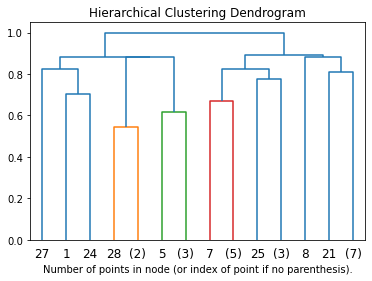

In [153]:
# import numpy as np

# from matplotlib import pyplot as plt
# from scipy.cluster.hierarchy import dendrogram
# from sklearn.cluster import AgglomerativeClustering


# def plot_dendrogram(model, **kwargs):
#     # Create linkage matrix and then plot the dendrogram

#     # create the counts of samples under each node
#     counts = np.zeros(model.children_.shape[0])
#     n_samples = len(model.labels_)
#     for i, merge in enumerate(model.children_):
#         current_count = 0
#         for child_idx in merge:
#             if child_idx < n_samples:
#                 current_count += 1  # leaf node
#             else:
#                 current_count += counts[child_idx - n_samples]
#         counts[i] = current_count

#     linkage_matrix = np.column_stack(
#         [model.children_, model.distances_, counts]
#     ).astype(float)

#     # Plot the corresponding dendrogram
#     dendrogram(linkage_matrix, **kwargs)


# X = X_std

# # setting distance_threshold=0 ensures we compute the full tree.
# model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='precomputed', linkage="complete")

# model = model.fit(X)
# plt.title("Hierarchical Clustering Dendrogram")
# # plot the top three levels of the dendrogram
# plot_dendrogram(model, truncate_mode="level", p=3)
# plt.xlabel("Number of points in node (or index of point if no parenthesis).")
# plt.show()

In [167]:
# model = AgglomerativeClustering(n_clusters=4, affinity='precomputed', linkage="complete")
# labels = model.fit_predict(X)

In [168]:
# np.unique(labels)

array([0, 1, 2, 3])

In [173]:
# df.index[labels == 3]

Index(['IBD.EUR.Crohns_Disease', 'CNCR_Insomnia_all',
       'BCAC_ER_positive_BreastCancer_EUR'],
      dtype='object')

# Conclusion

We need to compute three (3) gene correlation matrices for three groups of phenotypes:

* One for "rapid"
* One for "astle"
* One for the rest of the phenotypes

All phenotypes in the first two ("rapid" and "astle") have exactly the same SNPs, so the correlation matrix will be accurate for all those phenotypes.

For the third group, the correlation matrix will not be exactly accurate, but since they share more than 99% of the eQTLs, we assume it's enough.